In [1]:
import os
import os.path as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid", color_codes=True)
sns.set(font_scale=1.35, style="ticks") #set styling preferences
import statsmodels.api as sm
from scipy import stats
import math
from math import pi
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from scipy.spatial.distance import cdist
from scipy.cluster.vq import kmeans2,vq, whiten
import sidetable
import geopandas as gpd
import h5py
import boto.s3
import glob
import boto3
from zipfile import ZipFile
import shutil

In [2]:
# Show all columns and rows
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [5]:
%%time
s3 = boto3.client("s3")
key = "pilates-outputs/sfbay-rhprice0.0-rhfleet1.0-20220904/beam/year-2018-iteration-5/ITERS/it.0/0.events.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
dtypes = {
    "time": "float32",
    "type": "category",
    "legMode": "category",
    "actType": "category", 
    "primaryFuelLevel": "float64",
    "legMode": "category",
    "chargingPointType":"category",
    "pricingModel":"category",
    "parkingType":"category",
    "mode":"category",
    "personalVehicleAvailable": "category",
    "person": "object",
    "driver": "object",
    "riders": "object",
    'primaryFuelType': "category",
    'secondaryFuelType': 'category',
    'currentTourMode': 'category',
    'currentActivity': 'category',
    'nextActivity': 'category'    
}
eventsSF = pd.read_csv(obj['Body'], compression = 'gzip', dtype = dtypes)

<timed exec>:25: DtypeWarning: Columns (7,12,13,18,42,49,53,57) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 3min 25s
Wall time: 3min 25s


In [6]:
key = "pilates-outputs/sfbay-rhprice0.0-rhfleet1.0-20220904/activitysim/year-2018-iteration-5/final_trips.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
trips = pd.read_csv(obj['Body'], compression = 'gzip')

In [20]:
key = "pilates-outputs/sfbay-rhprice0.0-rhfleet1.0-20220904/activitysim/year-2018-iteration-5/persons.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
persons = pd.read_csv(obj['Body'], compression = 'gzip')

In [22]:
persons.head()

,person_id,earning,worker,student,hispanic.1,person_sex,PNUM,sex,household_id,hours,MAR,person_age,edu,school_zone_id,race_id,race,work_at_home,age,work_zone_id,p_hispanic,relate,hispanic,TAZ,ptype,pemploy,pstudent,home_x,home_y,age_16_to_19,age_16_p,adult,male,female,has_non_worker,has_retiree,has_preschool_kid,has_driving_kid,has_school_kid,has_full_time,has_part_time,has_university,student_is_employed,nonstudent_to_school,is_student,is_gradeschool,is_highschool,is_university,school_segment,is_worker,home_taz,value_of_time,school_taz,distance_to_school,roundtrip_auto_time_to_school,workplace_taz,workplace_location_logsum,distance_to_work,workplace_in_cbd,work_taz_area_type,roundtrip_auto_time_to_work,work_auto_savings,work_auto_savings_ratio,free_parking_at_work,cdap_activity,travel_active,under16_not_at_school,has_preschool_kid_at_home,has_school_kid_at_home,mandatory_tour_frequency,work_and_school_and_worker,work_and_school_and_student,num_mand,num_work_tours,num_joint_tours,non_mandatory_tour_frequency,num_non_mand,num_escort_tours,num_eatout_tours,num_shop_tours,num_maint_tours,num_discr_tours,num_social_tours,num_non_escort_tours
0,301489,25000.0,1,0,0,female,1,2,1085825,40.0,5,20 to 35,19.0,-1,1,white,0,33,6,no,0,0,11,1,1,3,-122.409100,37.778638,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,True,11,8.602250,-1,NaN,0.000000,7,14.287109,0.546548,True,0.0,7.395276,4.462117,0.037184,False,M,True,False,False,False,work1,False,False,1,1,0,1,1,0,0,0,0,1,0,1
1,407327,0.0,0,0,1,female,2,2,1701734,0.0,1,35 to 60,1.0,-1,1,white,0,39,-1,yes,1,1,553,4,3,3,-121.861757,37.336596,False,True,True,False,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False,0,False,553,34.212699,-1,NaN,0.000000,-1,NaN,NaN,False,NaN,0.000000,0.000000,0.000000,False,N,True,False,False,False,NaN,False,False,0,0,0,66,4,3,0,0,0,0,1,1
2,407328,0.0,0,1,1,female,4,2,1701734,0.0,5,19 and under,7.0,595,1,white,0,10,-1,yes,2,1,553,7,4,1,-121.861757,37.336596,False,False,False,False,True,True,False,False,True,True,True,False,False,False,False,True,True,False,False,1,False,553,22.819870,621,6.185060,16.750000,-1,NaN,NaN,False,NaN,0.000000,0.000000,0.000000,False,M,True,False,False,False,school1,False,False,1,0,0,16,1,0,0,1,0,0,0,1
3,407329,56000.0,1,0,1,male,1,1,1701734,60.0,1,20 to 35,9.0,-1,1,white,0,35,372,yes,0,1,553,1,1,3,-121.861757,37.336596,False,True,True,True,False,True,False,False,True,True,True,False,False,False,False,False,False,False,False,0,True,553,34.212699,-1,NaN,0.000000,360,14.155141,15.955543,False,4.0,38.875153,610.435550,1.000000,False,M,True,False,False,False,work2,False,False,2,2,0,0,0,0,0,0,0,0,0,0
4,407330,0.0,0,1,1,male,3,1,1701734,0.0,5,19 and under,11.0,553,1,white,0,13,-1,yes,2,1,553,7,4,1,-121.861757,37.336596,False,False,False,True,False,True,False,False,True,True,True,False,False,False,False,True,True,False,False,1,False,553,22.819870,560,2.841474,25.567778,-1,NaN,NaN,False,NaN,0.000000,0.000000,0.000000,False,M,True,False,False,False,school1,False,False,1,0,0,0,0,0,0,0,0,0,0,0


In [21]:
key = "pilates-outputs/sfbay-rhprice0.0-rhfleet1.0-20220904/activitysim/year-2018-iteration-5/households.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
households = pd.read_csv(obj['Body'], compression = 'gzip')

In [23]:
households.head()

,household_id,gt55,seniors,VEHICL,lcm_county_id,hh_children,block_id,gt2,hispanic_head,age_of_head,race_of_head,tenure_mover,hh_size,sf_detached,tenure,hh_cars,income,hh_age_of_head,serialno,num_workers,hh_race_of_head,hh_income,recent_mover,hh_workers,hispanic_status_of_head,hh_seniors,hhsize,hh_type,TAZ,HHT,sample_rate,chunk_id,income_in_thousands,income_segment,median_value_of_time,hh_value_of_time,num_non_workers,num_drivers,num_adults,num_children,num_young_children,num_children_5_to_15,num_children_16_to_17,num_college_age,num_young_adults,non_family,family,home_is_urban,home_is_rural,auto_ownership,hh_work_auto_savings_ratio,num_under16_not_at_school,num_travel_active,num_travel_active_adults,num_travel_active_preschoolers,num_travel_active_children,num_travel_active_non_preschoolers,participates_in_jtf_model,joint_tour_frequency,num_hh_joint_tours
0,1860018,0,0.0,1,6085,yes,60855048052024,1,no,34,6,rent recent,two,no,2,one,82000.0,lt35,2012000516276,1.0,asian,gt60-lt100,1,one,0,no,2,7,421,4,0.097,0,82.0,3,10.44,11.463059,1.0,1,1,1,1,0,0,0,1,True,False,False,False,1,1.0,0,2,1,1,1,1,True,0_tours,0
1,2311769,1,0.0,2,6095,no,60952527043003,1,no,58,2,own not recent,four or more,yes,1,two or more,187700.0,gt35-lt65,2010001263644,3.0,black,gt150,0,two or more,0,no,4,4,1255,4,0.097,95,187.7,4,12.86,50.000000,1.0,4,4,0,0,0,0,1,1,True,False,False,False,2,3.0,0,4,4,0,0,4,True,0_tours,0
2,622354,0,0.0,1,6013,no,60133430012000,0,no,53,1,own not recent,one,yes,1,one,90000.0,gt35-lt65,2009000420468,1.0,white,gt60-lt100,0,one,0,no,1,1,1144,1,0.097,190,90.0,3,10.44,13.977679,0.0,1,1,0,0,0,0,0,0,False,True,False,False,1,1.0,0,1,1,0,0,1,False,0_tours,0
3,2150206,0,0.0,3,6085,yes,60855123052001,1,no,49,1,own not recent,four or more,yes,1,two or more,171200.0,gt35-lt65,2012000679909,2.0,white,gt150,0,two or more,0,no,5,3,703,4,0.097,285,171.2,4,12.86,11.751845,3.0,4,4,1,0,1,0,2,0,True,False,False,False,3,2.0,0,5,4,0,1,5,True,0_tours,0
4,1068708,1,0.0,1,6055,no,60552005042009,0,no,61,1,own not recent,one,yes,1,one,100000.0,gt35-lt65,2009000469698,1.0,white,gt100-lt150,0,one,0,no,1,2,1297,1,0.097,380,100.0,3,10.44,3.716820,0.0,1,1,0,0,0,0,0,0,False,True,False,False,1,1.0,0,1,1,0,0,1,False,0_tours,0


In [18]:
eventsSF[eventsSF['person']=='17648']

,person,vehicle,time,type,mode,currentTourMode,expectedMaximumUtility,availableAlternatives,location,personalVehicleAvailable,length,tourIndex,legModes,legVehicleIds,currentActivity,nextActivity,tripId,driver,parkingTaz,chargingPointType,pricingModel,parkingType,score,endY,endX,startY,startX,arrivalTime,departureTime,link,facility,actType,departTime,locationY,locationX,secondaryFuelLevel,price,primaryFuelLevel,shiftStatus,parkingZoneId,fuel,duration,vehicleType,riders,toStopIndex,fromStopIndex,seatingCapacity,tollPaid,capacity,linkTravelTime,secondaryFuel,secondaryFuelType,primaryFuelType,links,numPassengers,primaryFuel,legMode,reason,incentive,tollCost,netCost,cost
1302109,17648,NaN,23731.0,ModeChoice,car_hov2,car_hov2,NaN,CAR_HOV2,19704.0,true,66633.514,1.0,"WALK,CAR_HOV2,CAR_HOV2,WALK","body-17648,637143,637143,body-17648",Home,atwork,5788729.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1302110,17648,NaN,23731.0,actend,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19704.0,NaN,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1302111,17648,NaN,23731.0,departure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19704.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,car_hov2,NaN,NaN,NaN,NaN,NaN
1302112,17648,body-17648,23731.0,PersonEntersVehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1302114,17648,637143,23731.0,PersonEntersVehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2524939,17648,NaN,26353.0,PersonCost,car_hov2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,7.308324,NaN
2524940,17648,637143,26353.0,PersonLeavesVehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2790376,17648,body-17648,26780.0,PersonLeavesVehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2790378,17648,NaN,26780.0,arrival,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,car_hov2,NaN,NaN,NaN,NaN,NaN
2790436,17648,NaN,26780.0,actstart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14146.0,NaN,atwork,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
eventsSF[eventsSF['tripId']==5788857]

,person,vehicle,time,type,mode,currentTourMode,expectedMaximumUtility,availableAlternatives,location,personalVehicleAvailable,length,tourIndex,legModes,legVehicleIds,currentActivity,nextActivity,tripId,driver,parkingTaz,chargingPointType,pricingModel,parkingType,score,endY,endX,startY,startX,arrivalTime,departureTime,link,facility,actType,departTime,locationY,locationX,secondaryFuelLevel,price,primaryFuelLevel,shiftStatus,parkingZoneId,fuel,duration,vehicleType,riders,toStopIndex,fromStopIndex,seatingCapacity,tollPaid,capacity,linkTravelTime,secondaryFuel,secondaryFuelType,primaryFuelType,links,numPassengers,primaryFuel,legMode,reason,incentive,tollCost,netCost,cost
9067726,17648,NaN,35443.0,ModeChoice,car_hov2,car_hov2,NaN,CAR_HOV2,20906.0,true,75107.087,1.0,"WALK,CAR_HOV2,CAR_HOV2,WALK","body-17648,637143,637143,body-17648",Work,work,5788857.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
trips[trips['person_id']==17648]

,trip_id,person_id,household_id,tour_id,primary_purpose,trip_num,outbound,trip_count,purpose,destination,origin,destination_logsum,depart,trip_mode,mode_choice_logsum
1356109,5788729,17648,1006665,723591,atwork,1,True,1,atwork,808,806,NaN,6.0,SHARED2FREE,2.410012
1356110,5788733,17648,1006665,723591,atwork,1,False,1,Work,806,808,NaN,6.0,SHARED2FREE,2.416952
1356111,5788857,17648,1006665,723607,work,1,True,1,work,806,1453,NaN,6.0,DRIVEALONEFREE,-2.983060
1356112,5788861,17648,1006665,723607,work,1,False,1,Home,1453,806,NaN,23.0,DRIVEALONEFREE,-2.755356


In [15]:
trips[trips['trip_id']==5788857]

,trip_id,person_id,household_id,tour_id,primary_purpose,trip_num,outbound,trip_count,purpose,destination,origin,destination_logsum,depart,trip_mode,mode_choice_logsum
1356111,5788857,17648,1006665,723607,work,1,True,1,work,806,1453,NaN,6.0,DRIVEALONEFREE,-2.98306


In [12]:
trips.head()

,trip_id,person_id,household_id,tour_id,primary_purpose,trip_num,outbound,trip_count,purpose,destination,origin,destination_logsum,depart,trip_mode,mode_choice_logsum
0,578577,1763,1017873,72322,work,1,True,1,work,383,1414,NaN,7.0,DRIVEALONEFREE,-3.255001
1,578581,1763,1017873,72322,work,1,False,1,Home,1414,383,NaN,19.0,DRIVEALONEPAY,-3.287092
2,578593,1764,1017873,72324,atwork,1,True,1,atwork,1346,1337,NaN,14.0,TNC_SINGLE,0.517102
3,578597,1764,1017873,72324,atwork,1,False,1,Work,1337,1346,NaN,14.0,TNC_SINGLE,0.876950
4,578905,1764,1017873,72363,work,1,True,1,work,1337,1414,NaN,9.0,DRIVEALONEFREE,-0.648073


In [24]:
%%time
baseline2018 = "https://beam-core-act.s3.amazonaws.com/deepDive/CleanData/SanFrancisco/Baseline/"
sfbase = pd.read_csv(baseline2018 + 'sf_2018_base_8_22_22.csv')

<timed exec>:2: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 1min 31s
Wall time: 4min 41s


In [25]:
sfbase.head()

,IDMerged,tripIndex,BlockGroupEnd,BlockGroupStart,actEndTime,actEndType,actStartTime,actStartType,cost_BEAM,distance_bike,distance_mode_choice,distance_privateCar,distance_ridehail,distance_transit,distance_travelling,distance_walking,duration_in_privateCar,duration_in_ridehail,duration_in_transit,duration_on_bike,duration_travelling,duration_walking,emissionBiodiesel,emissionDiesel,emissionElectricity,emissionFood,emissionGasoline,emission_marginal,fuelBiodiesel,fuelDiesel,fuelElectricity,fuelFood,fuelGasoline,fuel_marginal,fuel_not_Food,vehicleIds_estimate,lever,lever_position,mode_choice_actual_BEAM,mode_choice_planned_BEAM,numPassengers,parkingType,reason,replanning_status,ride_hail_pooled,scenario,transit_bus,transit_cable_car,transit_rail,transit_subway,transit_tram,vehicleIds,year,duration_door_to_door,waitTime,actPurpose,mode_choice_actual_5,mode_choice_actual_6,trip_id,person_id,household_id,tour_id,primary_purpose_x,trip_num,outbound,trip_count,purpose,destination_x,origin_x,destination_logsum_x,depart,trip_mode_AS_trips,logsum_trip_mode_AS_trips,tour_type,tour_type_count,tour_type_num,tour_num,tour_count,tour_category,number_of_participants,destination_y,origin_y,household_id_x,tdd,start,end,duration,composition,destination_logsum_y,tour_mode_AS_tours,logsum_tours_mode_AS_tours,atwork_subtour_frequency,parent_tour_id,stop_frequency,primary_purpose_y,earning,worker,student,hispanic.1,person_sex,PNUM,sex,household_id_y,hours,MAR,person_age,edu,school_zone_id,race_id,race,work_at_home,age,work_zone_id,p_hispanic,relate,hispanic,TAZ_x,ptype,pemploy,pstudent,home_x,home_y,age_16_to_19,age_16_p,adult,male,female,has_non_worker,has_retiree,has_preschool_kid,has_driving_kid,has_school_kid,has_full_time,has_part_time,has_university,student_is_employed,nonstudent_to_school,is_student,is_gradeschool,is_highschool,is_university,school_segment,is_worker,home_taz,value_of_time,school_taz,distance_to_school,roundtrip_auto_time_to_school,workplace_taz,workplace_location_logsum,distance_to_work,workplace_in_cbd,work_taz_area_type,roundtrip_auto_time_to_work,work_auto_savings,work_auto_savings_ratio,free_parking_at_work,cdap_activity,travel_active,under16_not_at_school,has_preschool_kid_at_home,has_school_kid_at_home,mandatory_tour_frequency,work_and_school_and_worker,work_and_school_and_student,num_mand,num_work_tours,num_joint_tours,non_mandatory_tour_frequency,num_non_mand,num_escort_tours,num_eatout_tours,num_shop_tours,num_maint_tours,num_discr_tours,num_social_tours,num_non_escort_tours,gt55,seniors,VEHICL,lcm_county_id,hh_children,block_id,gt2,hispanic_head,age_of_head,race_of_head,tenure_mover,hh_size,sf_detached,tenure,hh_cars,income,hh_age_of_head,serialno,num_workers,hh_race_of_head,hh_income,recent_mover,hh_workers,hispanic_status_of_head,hh_seniors,hhsize,hh_type,TAZ_y,HHT,sample_rate,chunk_id,income_in_thousands,income_segment,median_value_of_time,hh_value_of_time,num_non_workers,num_drivers,num_adults,num_children,num_young_children,num_children_5_to_15,num_children_16_to_17,num_college_age,num_young_adults,non_family,family,home_is_urban,home_is_rural,auto_ownership,hh_work_auto_savings_ratio,num_under16_not_at_school,num_travel_active,num_travel_active_adults,num_travel_active_preschoolers,num_travel_active_children,num_travel_active_non_preschoolers,participates_in_jtf_model,joint_tour_frequency,num_hh_joint_tours,DRIVEALONEFREE,DRIVEALONEPAY,SHARED2FREE,SHARED2PAY,SHARED3FREE,SHARED3PAY,WALK,BIKE,WALK_LOC,WALK_LRF,WALK_EXP,WALK_HVY,WALK_COM,DRIVE_LOC,DRIVE_LRF,DRIVE_EXP,DRIVE_HVY,DRIVE_COM,TAXI,TNC_SINGLE,TNC_SHARED
0,1,577.0,6.085503e+10,6.085504e+10,31052.0,Home,31247.0,othmaint,0.000000,0.0,4940.606,4940.606,0.0,0.0,4940.606,0.000,195.0,0.0,0.0,0.0,195.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.000000e+00,0.000000e+00,0.000000e+00,"body-1,teleportationSharedVehicle-1-1,body-1",default,1,hov2_teleportation,hov2_teleportation,NaN,NaN,NaN,0,0,baseline,0,0,0,0,0,NaN,2018,195.0,0.0,Home_to_othmaint,car,ca

In [7]:
%%time
baseline2018 = "https://beam-core-act.s3.amazonaws.com/deepDive/CleanData/SanFrancisco/Ridehail_Price/"
sfbase = pd.read_csv(baseline2018 + 'sf_2018_rh_price_2.csv')

<timed exec>:2: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 1min 32s
Wall time: 4min 17s


In [5]:
%%time
comb_stacked_path = "https://beam-core-act.s3.amazonaws.com/deepDive/CleanData/SanFrancisco/Stacked/"
comb_stacked = pd.read_csv(comb_stacked_path + 'sf_2018_stacked_rh_price_fleetsz_2p25.csv')

CPU times: total: 4min 11s
Wall time: 14min 47s


In [27]:
a = comb_stacked[comb_stacked['lever_position_fleetsize']==2.25]

In [29]:
comb_stacked[comb_stacked['mode_choice_planned_BEAM'] != comb_stacked['mode_choice_actual_BEAM']].head()

,IDMerged,tripIndex,scenario,lever,lever_position_fleetsize,Realized_INEXUS,logsum_relative_to_baseline,door_to_door_time_relative_to_baseline,income,actPurpose,lever_position_price,mode_choice_actual_BEAM,mandatoryCat,logsum_trip_Potential_INEXUS,actEndTime,actEndType,actStartTime,actStartType,cost_BEAM,distance_bike,distance_mode_choice,distance_privateCar,distance_ridehail,distance_transit,distance_travelling,distance_walking,duration_in_privateCar,duration_in_ridehail,duration_in_transit,duration_on_bike,duration_travelling,duration_walking,emissionBiodiesel,emissionDiesel,emissionElectricity,emissionFood,emissionGasoline,emission_marginal,fuelBiodiesel,fuelDiesel,fuelElectricity,fuelFood,fuelGasoline,fuel_marginal,fuel_not_Food,mode_choice_planned_BEAM,numPassengers,parkingType,reason,replanning_status,ride_hail_pooled,transit_bus,transit_cable_car,transit_rail,transit_subway,transit_tram,vehicleIds,year,duration_door_to_door,waitTime,mode_choice_actual_5,mode_choice_actual_6,trip_id,person_id,household_id,tour_id,primary_purpose_x,trip_count,purpose,trip_mode_AS_trips,tour_type,tour_category,start,end,duration,tour_mode_AS_tours,earning,person_sex,sex,edu,race,work_at_home,age,value_of_time,free_parking_at_work,num_mand,lcm_county_id,tenure_mover,hh_size,tenure,hh_cars,hh_income,hhsize,income_in_thousands,median_value_of_time,hh_value_of_time,home_is_urban,home_is_rural,auto_ownership,DRIVEALONEFREE,DRIVEALONEPAY,SHARED2FREE,SHARED2PAY,SHARED3FREE,SHARED3PAY,WALK,BIKE,WALK_LOC,WALK_LRF,WALK_EXP,WALK_HVY,WALK_COM,DRIVE_LOC,DRIVE_LRF,DRIVE_EXP,DRIVE_HVY,DRIVE_COM,TAXI,TNC_SINGLE,TNC_SHARED,income_quartiles,MedianQuartiles,alpha,socialCarbonCost,Social_INEXUS,Potential_INEXUS_in_dollar,Realized_INEXUS_in_dollar
256,180,59241.0,ridehail,price_fleetsize,2.25,-0.703254,0.831708,296.0,50700.0,Home_to_othdiscr,0.05,car,NaN,0.244296,44168.0,Home,44688.0,othdiscr,1.409505,0.0,7605.930000,3733.654,0.000,0.000000,3872.276000,138.622,181.0,0.0,0.0,0.0,288.0,107.0,0.0,0.000000,0.0,0.0,0.000389,0.000000,0.0,0.000000e+00,0.0,7346.966,5.257461e+06,5.264808e+06,5.257461e+06,ride_hail_pooled,"1.0, 1.0, 0.0, 0.0, 1.0","Residential, Public",ResourceUnavailable RIDE_HAIL_POOLED,1,1,0,0,0,0,0,"body-180, 698322",2018,520.0,232.0,car,car,59241,180,779945,7405,othdiscr,1,othdiscr,TNC_SINGLE,othdiscr,non_mandatory,12.0,17.0,5.0,DRIVEALONEFREE,4700.0,male,1,16.0,white,0,35,1.129980,False,0,6013,own not recent,three,1,two or more,gt30-lt60,3,50.7,8.81,1.129980,False,False,3,-0.703254,-0.731506,-999.703254,-999.719398,-999.703254,-999.714555,-12.074241,-1000.624266,-1000.702354,-1998.370594,-1998.370594,-1998.370594,-1998.370594,-1000.113785,-2002.609909,-1998.417466,-2002.265860,-1998.417466,-11.046186,-0.487343,-0.807432,2ndQ,70000.0,0.1,0.000000,-7.032543,2.442955,-7.032543
378,277,91173.0,ridehail,price_fleetsize,2.25,-0.979787,0.074262,252.0,276000.0,work_to_Home,0.05,ride_hail_pooled,from_M_to_H,-0.003564,43808.0,work,45990.0,Home,13.237752,0.0,40443.616000,0.000,31493.133,0.000000,31493.133000,0.000,0.0,1563.0,0.0,0.0,1563.0,0.0,0.0,0.000000,0.0,0.0,0.004728,0.000409,0.0,0.000000e+00,0.0,0.000,6.396205e+07,6.396205e+07,6.396205e+07,ride_hail,"1.0, 1.0, 1.0, 2.0, 3.0, 2.0, 1.0, 1.0",NaN,ResourceUnavailable RIDE_HAIL,1,3,0,0,0,0,0,"body-277, rideHailVehicle-2226417@default",2018,2182.0,619.0,ride_hail,ride_hail,91173,277,745372,11396,work,1,Home,TNC_SINGLE,work,mandatory,9.0,12.0,3.0,TNC_SINGLE,125000.0,female,2,22.0,white,0,54,10.780311,False,2,6013,own not recent,three,1,two or more,gt150,3,276.0,12.86,10.780311,False,False,2,-999.746072,-999.746672,-6.848226,-6.848569,-7.737887,-7.738127,-49.075553,-1015.153757,-999.989700,-2.840063,-999.630640,-999.630640,-999.630640,-1998.337600,-1998.337600,-1998.337600,-1998.337600,-1998.337600,-6.965391,-0.095197,-0.979787,4thQ,219000.0,0.1,0.020856,-9.818727,-0.035642,-9.797871
1068,592,194490.0,ridehail,price_fleetsize,2.25,-0.534311,-0.014924,144.0,166100.0,escort_to_escort,1.50,walk,from_N_to_N,-0.10

In [53]:
comb_stacked.mode_choice_actual_BEAM.unique()

array(['hov2_teleportation', 'car', 'hov3_teleportation', 'walk',
       'ride_hail', 'car_hov2', 'ride_hail_pooled', 'walk_transit',
       'drive_transit', 'bike', 'car_hov3', 'ride_hail_transit',
       'bike_transit'], dtype=object)

In [33]:
#sfbase[(sfbase['mode_choice_actual_BEAM'] == 'walk')&(sfbase['Realized_INEXUS_in_dollar'] <-20000)].head()

In [47]:
wTime = comb_stacked[['IDMerged', 'tripIndex','end','start','duration', 'household_id','actPurpose',
               'waitTime', 'duration_travelling', 'duration_door_to_door','mode_choice_actual_BEAM', 'lever_position_fleetsize']]

In [48]:
wTime[wTime['IDMerged']== 1583162]

,IDMerged,tripIndex,end,start,duration,household_id,actPurpose,waitTime,duration_travelling,duration_door_to_door,mode_choice_actual_BEAM,lever_position_fleetsize
2666778,1583162,519277361.0,17.0,16.0,1.0,1903246,Home_to_othmaint,460.0,166.0,626.0,ride_hail_pooled,1.00
2666779,1583162,519277361.0,17.0,16.0,1.0,1903246,Home_to_othmaint,245.0,228.0,473.0,ride_hail_pooled,2.25
2666780,1583162,519277361.0,17.0,16.0,1.0,1903246,Home_to_othmaint,64.0,218.0,282.0,ride_hail_pooled,2.25
2666781,1583162,519277361.0,17.0,16.0,1.0,1903246,Home_to_othmaint,261.0,306.0,567.0,ride_hail_pooled,2.25
2666782,1583162,519277361.0,17.0,16.0,1.0,1903246,Home_to_othmaint,971.0,219.0,1190.0,ride_hail_pooled,2.25
2666783,1583162,519277365.0,17.0,16.0,1.0,1903246,othmaint_to_Home,442.0,122.0,564.0,ride_hail_pooled,1.00
2666784,1583162,519277365.0,17.0,16.0,1.0,1903246,othmaint_to_Home,570.0,51.0,621.0,ride_hail_pooled,2.25
2666785,1583162,519277365.0,17.0,16.0,1.0,1903246,othmaint_to_Home,334.0,151.0,485.0,ride_hail_pooled,2.25
2666786,1583162,519277365.0,17.0,16.0,1.0,1903246,othmaint_to_Home,826.0,237.0,1063.0,ride_hail_pooled,2.25
2666787,1583162,519277365.0,17.0,16.0,1.0,1903246,othmaint_to_Home,273.0,313.0,586.0,ride_hail_pooled,2.25


In [63]:
rh_wTime = wTime[(wTime['mode_choice_actual_BEAM'] == 'ride_hail')|(wTime['mode_choice_actual_BEAM'] == 'ride_hail_pooled')]

In [58]:
rh_wTime = wTime[(wTime['mode_choice_actual_BEAM'] == 'ride_hail_transit')&(wTime['lever_position_fleetsize']==2.25)]

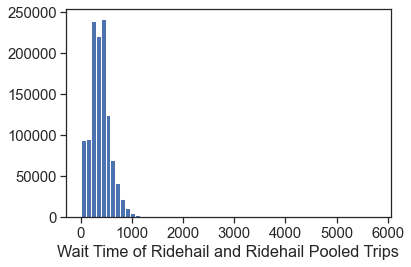

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.hist(rh_wTime['waitTime'], bins=60)
ax.set_xlabel('Wait Time of Ridehail and Ridehail Pooled Trips')
fig.tight_layout()

In [7]:
comb_stacked[(comb_stacked['waitTime']==0)&(comb_stacked['mode_choice_planned_BEAM']=='ride_hail_pooled')].shape

(0, 127)